In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.base import BaseForecaster
import itertools
import csv
from ngboost import NGBRegressor
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import norm

from Forcasting_lib import load_fred_data, make_stationary, standardize_data

In [ ]:
## load and transform data
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

Datei 'current.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


In [3]:
## Daten vorbereiten
data_all = df_std[cols_to_standardize].dropna()

# Ziel und Prädiktoren trennen
y_all = data_all["GDPC1"]
X_all = data_all.drop(columns=["GDPC1"])  

In [4]:
def evaluate_GB_forecaster(y_all, X_all, initial_window=100, window_length =5, n_estimators=200, learning_rate = 0.1, max_depth= 4, subsample =0.8):
    # Expanding Window Splitter definieren
    splitter = ExpandingWindowSplitter(
        initial_window=initial_window, # Erstes Trainingsfenster
        fh=1,   # Forecast horizon (1 Zeitschritt in die Zukunft)
        step_length=1 # Schrittweite für das Fenster
    )

    # Regressionsmodell einbinden (Gradient Boosting mit Lag-Features)
    forecaster = make_reduction(
        GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample),
        strategy="direct",
        window_length=window_length,
        scitype="tabular-regressor"
    )

    y_preds = []
    y_trues = []


    for train_idx, test_idx in splitter.split(y_all):
        y_train = y_all.iloc[train_idx]
        X_train = X_all.iloc[train_idx]
        y_test = y_all.iloc[test_idx]
        X_test = X_all.iloc[test_idx]

        fh_relative = ForecastingHorizon(test_idx - train_idx[-1], is_relative=True)

        forecaster.fit(y_train, X=X_train, fh=1)
        y_pred = forecaster.predict(fh=fh_relative, X=X_test)

        y_preds.extend(y_pred.values)
        y_trues.extend(y_test.values)


    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues
    


In [5]:
rmse, y_preds, y_trues = evaluate_GB_forecaster(y_all[:150], X_all[:150], initial_window=100, window_length=1, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8)

In [5]:
def evaluate_NGB_forecaster_CI(y_all, X_all, initial_window=150,
                                n_estimators=100, learning_rate=0.1,
                                max_depth=2):
    
    y_preds = []
    y_trues = []
    lower_bounds = []
    upper_bounds = []
    y_dist = []

    for i in range(initial_window, len(y_all) - 1):
        # Trainingsdaten bis Zeitpunkt i
        X_train = X_all.iloc[:i]
        y_train = y_all.iloc[:i]

        # Vorhersagezeitpunkt: i (mit X von i), testen gegen y_{i}
        X_test = X_all.iloc[i].values.reshape(1, -1)
        y_test = y_all.iloc[i]

        model = NGBRegressor(
            Dist=Normal,
            Base=DecisionTreeRegressor(max_depth=max_depth),
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            verbose=False
        )
        model.fit(X_train, y_train)

        # Vorhersageverteilung für X_test
        dist = model.pred_dist(X_test)
        mean = dist.loc[0]
        std = dist.scale[0]

        # 95%-Konfidenzintervall
        z = norm.ppf(0.975)
        lower = mean - z * std
        upper = mean + z * std

        y_preds.append(mean)
        y_trues.append(y_test)
        lower_bounds.append(lower)
        upper_bounds.append(upper)
        y_dist.append(dist)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues, lower_bounds, upper_bounds, y_dist

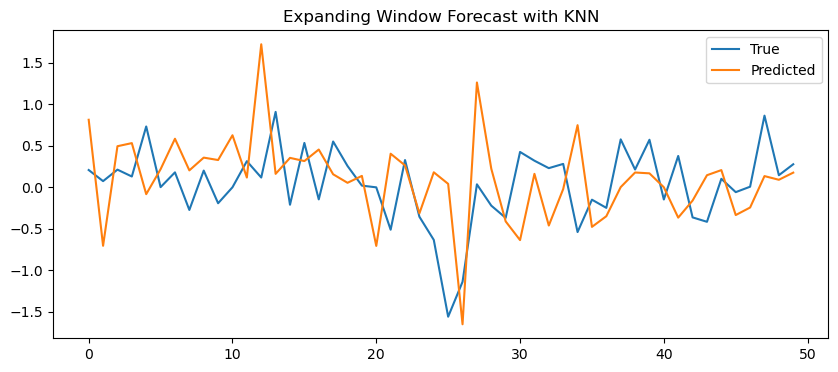

RMSE: 0.621


In [6]:
# Auswertung
plt.figure(figsize=(10, 4))
plt.plot(y_trues, label='True')
plt.plot(y_preds, label='Predicted')
plt.legend()
plt.title("Expanding Window Forecast with KNN")
plt.show()

print(f"RMSE: {rmse:.3f}")

### Use Grid Search to optimize Hyper Parameter 

In [7]:
## erzeuge durch Iteration alle Kombinationen der Hyperparameter 
param_grid = {
    'window_length': [2,3,4,5],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

param_grid = list(itertools.product(*param_grid.values()))

In [8]:
results = []
for window_length, n_estimators, learning_rate, max_depth, subsample in param_grid:
    rmse, y_trues, y_preds = evaluate_GB_forecaster(
        y_all = y_all[:150], 
        X_all = X_all[:150], 
        initial_window = 100, 
        window_length = window_length, 
        n_estimators = n_estimators, 
        learning_rate = learning_rate, 
        max_depth = max_depth, 
        subsample = subsample)
    rmse = np.sqrt(mean_squared_error(y_trues[-50:], y_preds[-50:]))
    print(f"Params: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, subsample={subsample}, window_length={window_length}, RMSE: {rmse:.3f}")
    results.append(((window_length, n_estimators, learning_rate, max_depth, subsample), rmse))

Params: n_estimators=100, learning_rate=0.01, max_depth=3, subsample=0.8, window_length=2, RMSE: 0.444
Params: n_estimators=100, learning_rate=0.01, max_depth=3, subsample=1.0, window_length=2, RMSE: 0.441
Params: n_estimators=100, learning_rate=0.01, max_depth=4, subsample=0.8, window_length=2, RMSE: 0.440
Params: n_estimators=100, learning_rate=0.01, max_depth=4, subsample=1.0, window_length=2, RMSE: 0.437
Params: n_estimators=100, learning_rate=0.01, max_depth=5, subsample=0.8, window_length=2, RMSE: 0.449
Params: n_estimators=100, learning_rate=0.01, max_depth=5, subsample=1.0, window_length=2, RMSE: 0.455
Params: n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8, window_length=2, RMSE: 0.488
Params: n_estimators=100, learning_rate=0.05, max_depth=3, subsample=1.0, window_length=2, RMSE: 0.483
Params: n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.8, window_length=2, RMSE: 0.499
Params: n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0,

In [9]:
# Speichere die Ergebnisse als CSV
with open("./Data/results_GB.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Schreibe Header
    writer.writerow(["window_length", "n_estimators", "learning_rate", "max_depth", "subsample", "rmse"])
    # Schreibe jede Zeile
    for params, rmse in results:
        writer.writerow([params[0], params[1], params[2], params[3], params[4], rmse])

In [6]:
results = pd.read_csv("./Data/results_GB.csv")
best_params  = results.loc[results['rmse'].idxmin()]
print(f"Best parameter combination: window_length={best_params[0]}, n_estimators={best_params[1]}, learning_rate={best_params[2]}, subsample = {best_params[3]}, max_depth = {best_params[3]}, RMSE={best_params[4]:.4f}")

Best parameter combination: window_length=3.0, n_estimators=100.0, learning_rate=0.01, subsample = 3.0, max_depth = 3.0, RMSE=1.0000


/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_30454/1039090733.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Best parameter combination: window_length={best_params[0]}, n_estimators={best_params[1]}, learning_rate={best_params[2]}, subsample = {best_params[3]}, max_depth = {best_params[3]}, RMSE={best_params[4]:.4f}")


### Make Final Prediction 

In [12]:
rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 150,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8876/1138832000.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8876/1138832000.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8876/1138832000.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

RMSE (for the test set): 1.1978


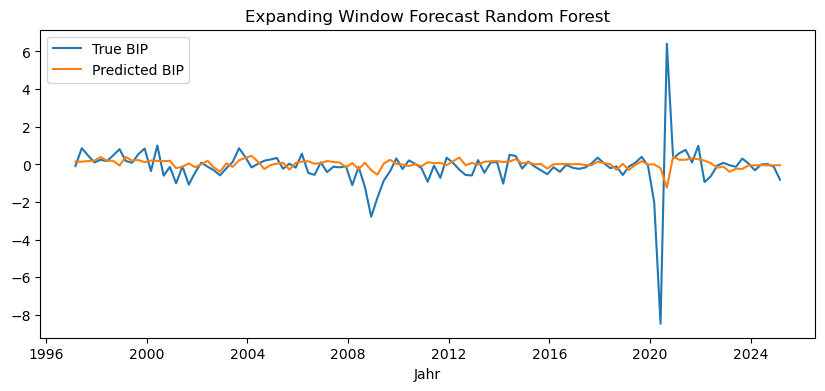

RMSE: 1.198


In [ ]:
# Auswertung
dates = y_all.index[-len(y_preds):]  
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast Random Forest")
plt.savefig("./plots/final_forecast_GB.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [14]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds
})


results_df.to_csv('./Data/results/GB_forecast_results.csv', index=False)

### Mit Konfidenzintervallen

In [7]:
rmse, y_preds, y_trues, lower_bounds, upper_bounds, dist  = evaluate_NGB_forecaster_CI(y_all, X_all, initial_window=150, n_estimators=200, learning_rate=0.1, max_depth=4)

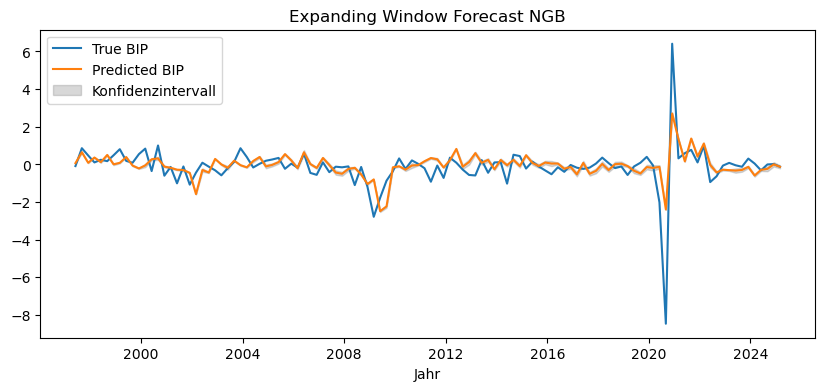

RMSE: 0.869


In [8]:
# Auswertung
dates = data_all.index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
# Konfidenzintervalle als graue Schattierung hinzufügen
plt.fill_between(dates, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='Konfidenzintervall')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast NGB")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [10]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds,
    'dist': [d.loc for d in dist],
})


results_df.to_csv('./Data/results/GB_forecast_results_CI.csv', index=False)

### Nutze größeren Prädiktoren Satz 

In [11]:
cols_to_standardize = [
    'GDPC1',      # Reales BIP, Zielvariable
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'TB3MS',       # Rendite 3-monatiger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500',    # S&P 500 Index
    'PCECC96',    # PCE-Kerninflation
    'GPDIC1',     # Bruttoinlandsinvestitionen (real)
    'PNFIx',      # Private nichtwohnwirtschaftliche Investitionen
    'FPIx',       # Ausrüstungsinvestitionen
    'PCDGx',      # Konsum langlebiger Güter
    'PCNDx',      # Konsum nicht langlebiger Güter
    'PCESVx',     # Konsum von Dienstleistungen
    'CE16OV',     # Zivilbeschäftigung
    'CPIAUCSL',   # Verbraucherpreisindex (CPI)
    'PCEPILFE'    # PCE-Kerninflation
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

## Daten vorbereiten
data_all = df_std[cols_to_standardize].dropna()

# Ziel und Prädiktoren trennen
y_all = data_all["GDPC1"]
X_all = data_all.drop(columns=["GDPC1"])  

Standardisierung abgeschlossen.


In [12]:
rmse, y_preds, y_trues  = evaluate_GB_forecaster(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 150,  ## need to be 150 
        window_length = int(best_params[0]), 
        n_estimators = int(best_params[1]), 
        learning_rate = float(best_params[2]), 
        max_depth = int(best_params[3]), 
        subsample = float(best_params[4]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_30454/1138832000.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = int(best_params[0]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_30454/1138832000.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_estimators = int(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_30454/1138832000.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

RMSE (for the test set): 1.4265


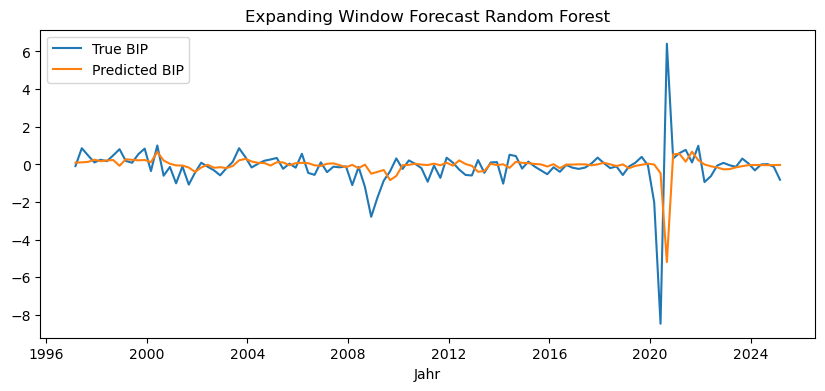

RMSE: 1.427


In [ ]:
# Auswertung
dates = y_all.index[-len(y_preds):] 
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast Random Forest")
#plt.savefig("./plots/final_forecast_2_GB.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [18]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds
})


results_df.to_csv('./Data/results/GB_forecast_2_results.csv', index=False)

### Predict Uncertainty Intervalls for the bigger Dataset

In [14]:
rmse, y_preds, y_trues, lower_bounds, upper_bounds, dist  = evaluate_NGB_forecaster_CI(y_all, X_all, initial_window=150, n_estimators=200, learning_rate=0.1, max_depth=4)

In [15]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds,
    'dist': [d.loc for d in dist],
})


results_df.to_csv('./Data/results/GB_forecast_results_CI_2.csv', index=False)

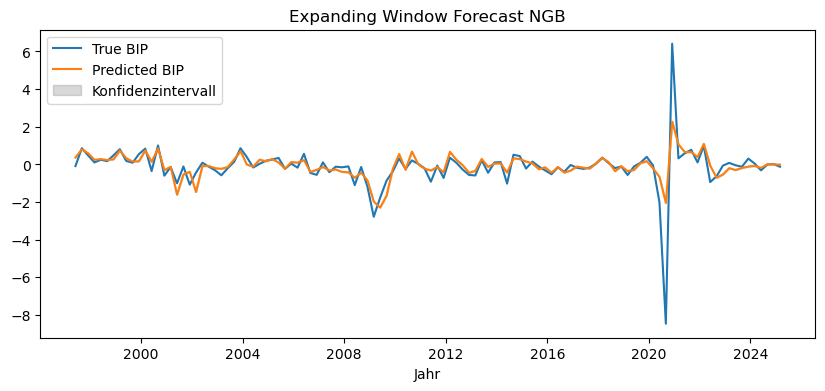

RMSE: 0.791


In [ ]:
# Auswertung
dates = data_all.index[-len(y_preds):]  
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
# Konfidenzintervalle als graue Schattierung hinzufügen
plt.fill_between(dates, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='Konfidenzintervall')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast NGB")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")